In [1]:
%matplotlib inline

In [2]:
from mne.inverse_sparse.mxne_inverse import _make_sparse_stc
from mne import read_forward_solution
from mne.viz import plot_sparse_source_estimates
import mne

import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import recall_score
from scipy.stats import wasserstein_distance

In [8]:
import os 

# please update your paths
os.environ['SUBJECTS_DIR'] = '/home/anujanegi/tj/bdsg/freesurfer/subjects'
PATH_TO_ESTIMATES = "bsi_zoo/tests/data/estimates"
PATH_TO_SAVE_FIGURES = "figures"
SOLVER_NAMES = ['iterative_L1', 'iterative_L2', 'iterative_sqrt', 'iterative_L1_typeII', 'iterative_L2_typeII', 'gamma_map']
SUBJECTS = ["CC120166", "CC120264", "CC120309", "CC120313"]

mne.viz.set_3d_backend('pyvista')
HEMISPHERES = ["lh", "rh"]
# ['iterative_L1' , 'iterative_L2', 'iterative_sqrt', 'iterative_L1_typeII', 'iterative_L2_typeII', 'gamma_map']

In [4]:
def metrics(fwd, stc, stc_hat):
    vertices = []
    vertices.append(fwd["src"][0]["vertno"])
    vertices.append(fwd["src"][1]["vertno"])

    # Reverse the effect of make_sparse_stc
    # stc now contains a sparse matrix with a lot of zero rows and few non-zero
    # rows containing the activations

    stc.expand(vertices)
    stc_hat.expand(vertices)

    est_activations = np.abs(stc_hat.data).sum(axis=-1)
    true_activations = np.abs(stc.data).sum(axis=-1)

    estimated_as = est_activations != 0
    true_as = true_activations != 0

    recall = recall_score(true_as, estimated_as, zero_division=0)
    emd = wasserstein_distance(est_activations, true_activations) #TODO: info about geometry

    return recall, emd

In [5]:
def add_margin(nonwhite_col, margin=5):
    margin_nonwhite_col = nonwhite_col.copy()
    for i in range(len(nonwhite_col)):
        if nonwhite_col[i] == True and nonwhite_col[i - 1] == False:
            margin_nonwhite_col[i - (1 + margin) : i - 1] = True
        elif nonwhite_col[i] == False and nonwhite_col[i - 1] == True:
            margin_nonwhite_col[i : i + margin] = True
    return margin_nonwhite_col

In [6]:
def add_foci_to_brain_surface(brain, stc, ax, color, label):
    for i_hemi, hemi in enumerate(HEMISPHERES):
        surface_coords = brain.geo[hemi].coords
        hemi_data = stc.lh_data if hemi == "lh" else stc.rh_data
        
        for k in range(len(stc.vertices[i_hemi])):
            activation_idx = stc.vertices[i_hemi][k]
            foci_coords = surface_coords[activation_idx]

            # In milliseconds
            (line,) = ax.plot(stc.times * 1e3, 1e9 * hemi_data[k], color=color, label=label)
            brain.add_foci(foci_coords, hemi=hemi, color=line.get_color(), alpha=0.5, name=label)

    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Amplitude (nAm)")
    ax.legend()

------------------------------
Making figures for iterative L2 typeII method for subject CC120166...
------------------------------
Reading forward solution from bsi_zoo/tests/data/CC120166-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
Using control points [1.55898695 1.56657165 1.57895999]


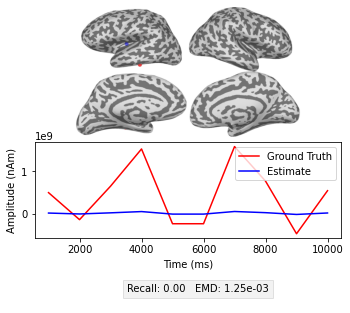

In [15]:
# for free orientation the active set needs to diminised to the same shape of fixed
for subject in SUBJECTS:
    for solver in SOLVER_NAMES:
            print('-'*30)
            print('Making figures for %s method for subject %s...'%(solver.replace('_', ' '), subject))
            print('-'*30)
            
            x = np.load(os.path.join(PATH_TO_ESTIMATES, subject, solver+'_x_10.npy'))
            x_hat = np.load(os.path.join(PATH_TO_ESTIMATES, subject, solver+'_x_hat_10.npy'))

            fwd_fname = "bsi_zoo/tests/data/%s-fwd.fif"%subject
            fwd = read_forward_solution(fwd_fname)
            fwd = mne.convert_forward_solution(fwd, force_fixed=True)
            active_set = np.linalg.norm(x, axis=1) != 0
            
            # check if no vertices are estimated
            temp = np.linalg.norm(x_hat, axis=1)
            if len(np.unique(temp))==1:
                print("No vertices estimated!")
                continue
            # hacky way
            active_set_hat = temp == np.max(temp)

            stc = _make_sparse_stc(
                x[active_set], active_set, fwd, tmin=1, tstep=1
            )  # ground truth
            stc_hat = _make_sparse_stc(
                x_hat[active_set_hat], active_set_hat, fwd, tmin=1, tstep=1
            )  # estimate
            
            source_space = mne.read_source_spaces(fwd_fname)
            
             # Plot the STC, get the brain image, crop it:
            brain = stc.plot(
                views=["lat", "med"],
                hemi="split" if len(HEMISPHERES) > 1 else HEMISPHERES[0],
                size=(500, 250),
                background="w",
                clim="auto",
                colorbar=False,
                colormap="inferno",
                time_viewer=False,
                show_traces=False,
                cortex="classic",
                volume_options=dict(resolution=1),
            )

            t = 10
            brain.set_time(t)

            fig = plt.figure(figsize=(5.5, 5.5))
            axes = [
                plt.subplot2grid((9, 1), (0, 0), rowspan=4),
                plt.subplot2grid((9, 1), (4, 0), rowspan=3),
                plt.subplot2grid((9, 1), (7, 0), rowspan=1), #hacky spacing
                plt.subplot2grid((9, 1), (8, 0), rowspan=1), #metrics
            ]

            add_foci_to_brain_surface(brain, stc, axes[1], color=(1, 0, 0), label='Ground Truth') #red
            add_foci_to_brain_surface(brain, stc_hat, axes[1], color=(0, 0, 1), label='Estimate') #blue

            screenshot = brain.screenshot()

            nonwhite_pix = (screenshot != 255).any(-1)
            nonwhite_row = nonwhite_pix.any(1)
            nonwhite_col = nonwhite_pix.any(0)

            # Add blank columns for margin
            nonwhite_col = add_margin(nonwhite_col)

            cropped_screenshot = screenshot[nonwhite_row][:, nonwhite_col]

            brain_idx = 0
            spacing_idx = 2 
            metrics_idx = 3

            axes[brain_idx].imshow(cropped_screenshot)
            axes[brain_idx].axis("off")
            
            axes[spacing_idx].axis("off")
            
            axes[metrics_idx].axis("off")
            # get metrics
            recall, emd = metrics(fwd, stc, stc_hat)
            axes[metrics_idx].text(0.3, 0.5, 'Recall: %.2f   EMD: %.2e'%(recall, emd), bbox=dict(facecolor='grey', alpha=0.1))
            
            fig.subplots_adjust(left=0.15, right=0.9, bottom=0.15, top=0.9, wspace=0.1,
                    hspace=0.2)

            fig.tight_layout()
            fig.savefig(os.path.join(PATH_TO_SAVE_FIGURES, 'combined','%s_%s.svg'%(solver, subject)))
            brain.close()

In [13]:
emd

0.0012509152309121067

In [14]:
'%.2e' % emd

'1.25e-03'

In [8]:
#             plot_sparse_source_estimates(
#                 source_space, [stc, stc_hat], bgcolor=(1, 1, 1),
#                 fig_name=solver, opacity=0.1, colors=['r','b']
#             )

In [9]:
#             brain = mne.viz.Brain(
#                 subject_id=subject,
#                 views=["lat", "med"],
# #                 views=["lat"],
#                 hemi="split" if len(HEMISPHERES) > 1 else HEMISPHERES[0],
#                 size=(500, 250),
#                 # size=(500, 500),
#                 background="w",
#                 surf='inflated',
#                 cortex="classic",
#                 show_toolbar=True
#             )

#             brain.add_text(34, 50,'dsd',name='dsdsadsadasdaa', row=0, col=0)
#             fig, ax = plt.subplots(1, 1)
#             add_foci_to_brain_surface(brain, stc, ax, color=(1, 0, 0), label='Ground Truth') #red
#             add_foci_to_brain_surface(brain, stc_hat, ax, color=(0, 0, 1), label='Estimate') #blue
#             fig.suptitle('Solver: %s'%solver)
#             plt.savefig(os.path.join(PATH_TO_SAVE_FIGURES, '%s_%s.jpg'%(solver, subject)))
#             brain.save_image(os.path.join(PATH_TO_SAVE_FIGURES, '%s_%s.png'%(solver, subject)))
#             brain.close()